In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn
seaborn.set_style('white')
import hoag  
import mod_l_exp.utils as mlx
import numpy as np

### GENERATE DATASET

In [2]:
dataset = mlx.generate_multiclass_dataset(n_samples=90000, n_features=1000, n_informative=50, n_redundant=25, n_repeated=0,
                                      n_classes=2, n_clusters_per_class=3,
                                      flip_y=0.1, class_sep=1.0,
                                      random_state=1, hot_encoded=False, partitions_proportions=[1/3, 1/3])

datasets.redivide_data:, computed partitions numbers - [0, 30000, 60000, 90000] len all 90000 DONE


### RESPONSE  FUNCTION for $\alpha$

Setting: we use logistic regression (for binary classification) and optimize regularization hyper-parameter

In [9]:
from sklearn import linear_model

alphas = np.linspace(-0, 20, 50)

def cost_func(a):
    clf = linear_model.LogisticRegression(
        solver='lbfgs',
        C=np.exp(-a), fit_intercept=True, 
        tol=1e-15, max_iter=500)

    clf.fit(dataset.train.data, dataset.train.target)
    cost = linear_model.logistic._logistic_loss(clf.coef_.ravel(), 
                                                dataset.validation.data, dataset.validation.target, 0.)
    print('.', end='')
    return cost

In [10]:
scores = [cost_func(a) for a in alphas]

..................................................

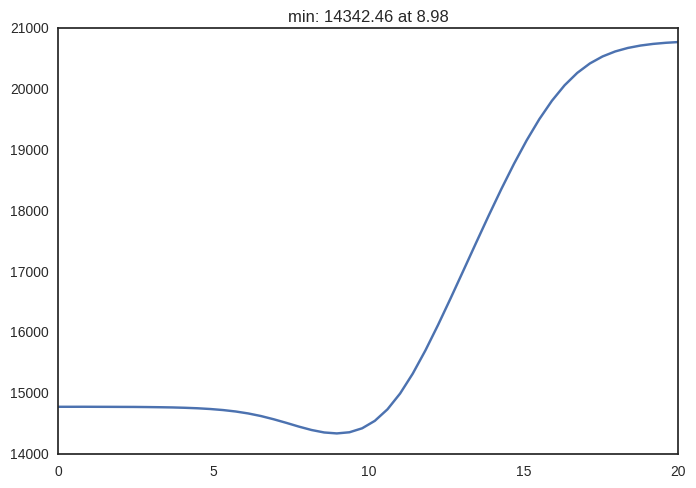

In [11]:
plt.plot(alphas, scores)
plt.title('min: %.2f at %.2f' % (np.min(scores), alphas[np.argmin(scores)]));

### HOAG - NO BOUNDS ON $\alpha$

In [12]:
from mod_l_exp.rfho_exp import *

In [5]:
saver = rf.Saver(['HOAG comparrison', 'from forked hoag'])
# saver = None

folder /media/luca/DATA/EXPERIMENTS/HOAG comparrison/from forked hoag/19-07-17__15h31m has been created


In [15]:
identity = lambda x: x
saver.timer.reset()
clf, res_h = mlx.hoag_fit(saver, dataset, alpha0=0., projection=identity, max_iter=100)

started hoag
WARNING, No tensorflow session available
Step 0                      Values
-------------------  -------------
training error       1114596.05706
validation error     1132312.25605
test error           1130279.24706
validation accuracy        0.50117
test accuracy              0.49827
alpha                      0.00000
der alpha                  0.00000
step size                  0.00000
Elapsed time (sec)         0.00000
inner level iterations: 130, inner objective 13631.4713413, grad norm 198.52092129127848
Inverting matrix with precision 0.001
increased step size
it 1, g: 14729.8013085, incr: -inf, sum lambda 2.0, epsilon: 0.0009000000000000001, L: 23.1495675306, norm grad_lambda: 24.3679658217
WARNING, No tensorflow session available
Step 1                    Values
-------------------  -----------
training error       13643.70734
validation error     14729.80131
test error           14748.67916
validation accuracy      0.77240
test accuracy            0.77530
alpha   

A file named /media/luca/DATA/EXPERIMENTS/HOAG comparrison/from forked hoag/19-07-17__15h31m/Plots/HOAG.pdf already exists. Overwrite (Leave string empty for NO!)?y


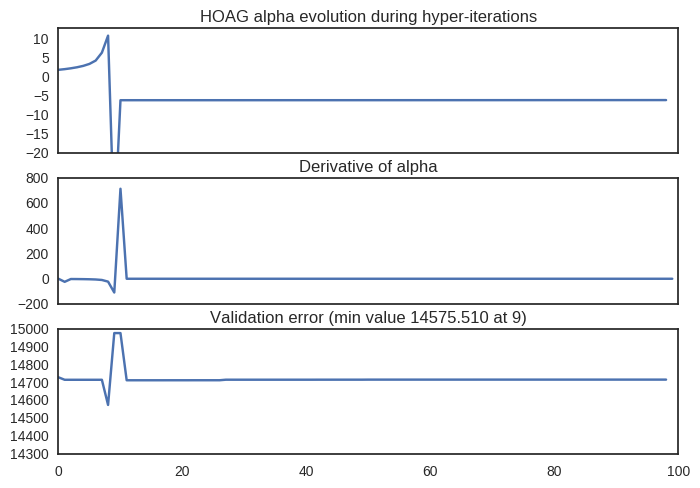

In [16]:
fig, ax = plt.subplots(nrows=3, sharex=True)
ax[0].plot(res_h['alpha'][1:])
ax[0].set_ylim(-20, 13)
ax[0].set_title('HOAG alpha evolution during hyper-iterations')
ax[1].plot(res_h['der alpha'])
ax[1].set_title('Derivative of alpha')

ax[2].set_ylim(14300, 15000)
ax[2].plot(res_h['validation error'][1:])
ax[2].set_title('Validation error (min value %.3f at %d)' % 
                (np.min(res_h['validation error']), np.argmin(res_h['validation error'])))  # the one we're optimizing
if saver: saver.save_fig('HOAG')

In [7]:
tf.reset_default_graph()
saver.timer.reset()
res = rtho_experiment(dataset, saver, optimizer_kwargs={'mu': tf.constant(.5), 'lr': tf.constant(1.e-7)}, 
                      # very small learning rate since the error is not normalized
                      hyper_iterations=800,  # more or less it converges
                    hyper_optimizer_class=rf.AdamOptimizer, 
                    hyper_optimizer_kwargs={'lr':tf.constant(1.e-2)}, 
                      # hyper step size is 10 times our proposed "default value" to speed 
                      # things up...
                   hyper_batch_size=10)

Step 0                                 Values
-------------------------------------  --------------
training error                         20794.39453125
validation error (sum)                 20794.39453125
test error (sum - validation in HOAG)  20794.39453125
validation accuracy                    0.0
test accuracy                          0.0
norm of weights                        0.0
alpha                                  [0.0, 0.0]
Elapsed time (sec)                     0
folder /media/luca/DATA/EXPERIMENTS/HOAG comparrison/from forked hoag/19-07-17__15h31m/Obj_data has been created
Step 1                                 Values
-------------------------------------  ---------------------------
training error                         16621.255859375
validation error (sum)                 16756.10546875
test error (sum - validation in HOAG)  16602.884765625
validation accuracy                    0.7237671613693237
test accuracy                          0.733467161655426
norm of weigh

folder /media/luca/DATA/EXPERIMENTS/HOAG comparrison/from forked hoag/19-07-17__15h31m/Plots has been created


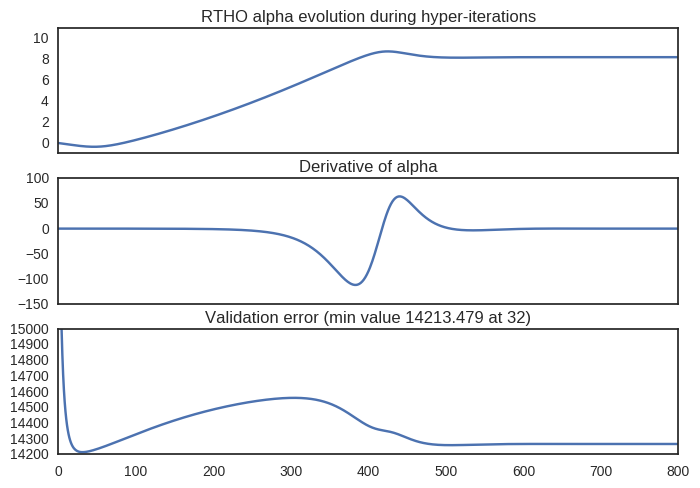

In [8]:
fig, ax = plt.subplots(nrows=3, sharex=True)
ax[0].plot([e[0] for e in res['alpha'][1:]])
ax[0].set_ylim(-1, 11)
ax[0].set_title('RTHO alpha evolution during hyper-iterations')
ax[1].plot([e[1] for e in res['alpha']])
ax[1].set_title('Derivative of alpha')

ax[2].set_ylim(14200, 15000)
ax[2].plot(res['validation error (sum)'][1:])
ax[2].set_title('Validation error (min value %.3f at %d)' % 
                (np.min(res['validation error (sum)']),
                 np.argmin(res['validation error (sum)'])))  # the one we're optimizing
if saver: saver.save_fig('RTHO plots')